# Machine Translation Project: English to French

## Introduction

This project leverages **Natural Language Processing (NLP)** techniques to build a machine translation model capable of translating text from English to French. Machine translation is a critical application of NLP, bridging communication gaps across languages by automating the translation process.

The model is trained on a parallel English-French dataset, utilizing sequence-to-sequence architecture with recurrent neural networks (RNNs). The goal is to achieve high-quality translations that capture both the syntax and semantics of the original text.

### Key Objectives:
1. Understand the fundamentals of machine translation and sequence learning.
2. Preprocess and tokenize datasets for bilingual translation tasks.
3. Build and evaluate a machine translation model.

This project demonstrates the practical implementation of NLP for solving real-world language translation challenges.


In [ ]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import random  # For generating random values (for sampling a random index)
import string  # For working with strings (removing punctuation)
import matplotlib.pyplot as plt  # For creating visualizations

import nltk  # Natural Language Toolkit for NLP tasks
from nltk.tokenize import word_tokenize  # Tokenize text into individual words

from tensorflow.keras.preprocessing.text import Tokenizer  # For converting text to sequences of integers
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to uniform lengths
from tensorflow.keras.models import Sequential  # For building a sequential neural network
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense  # Layers for the model
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model
from tensorflow.keras.layers import Bidirectional  # For creating a bidirectional LSTM layer

In [ ]:
english = pd.read_csv("en.csv")
english.head(2)

,"new jersey is sometimes quiet during autumn , and it is snowy in april ."
0,the united states is usually chilly during jul...
1,"california is usually quiet during march , and..."


In [ ]:
french = pd.read_csv("fr.csv")
french.head(2)

,"new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."
0,les états-unis est généralement froid en juill...
1,"california est généralement calme en mars , et..."


In [ ]:
print(f"The English file has {len(english)} English sentences")
print(f"The French file has {len(french)} French sentences")

The English file has 137859 English sentences
The French file has 137859 French sentences


**Both files have 137,859 sentences, where each English sentence matches its French translation. This makes the dataset ideal for training a machine translation model.**

In [ ]:
#We combine the English and French datasets into a single DataFrame

df = pd.concat([english, french], axis = 1)
df.head(2)

,"new jersey is sometimes quiet during autumn , and it is snowy in april .","new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."
0,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
1,"california is usually quiet during march , and...","california est généralement calme en mars , et..."


In [ ]:
#We rename the columns of the DataFrame to 'English' and 'French' for better clarity

df.columns = ['English', 'French']
df.head(2)

,English,French
0,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
1,"california is usually quiet during march , and...","california est généralement calme en mars , et..."


In [ ]:
#We randomly select an index and retrieve the corresponding English and French sentences using that index.

random_index = random.randint(0, len(df) - 1)

english_sentence = df['English'].iloc[random_index]
french_sentence = df['French'].iloc[random_index]

print("English:", english_sentence)
print("French:", french_sentence)

English: paris is never busy during autumn , but it is usually dry in february .
French: paris est jamais occupé à l'automne , mais il est généralement sec en février .


**This is a randomly selected sentence pair, where the English sentence is matched with its French translation, which helps train the translation model.**

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['English'] = df['English'].apply(remove_punctuation)
df['French'] = df['French'].apply(remove_punctuation)

**This step removes punctuation from both the English and French sentences to ensure the model focuses on the core words rather than punctuation marks.**

In [ ]:
print("English (No punctuation):", df['English'].iloc[random_index])
print("French (No punctuation):", df['French'].iloc[random_index])

English (No punctuation): paris is never busy during autumn  but it is usually dry in february 
French (No punctuation): paris est jamais occupé à lautomne  mais il est généralement sec en février 


**We can clearly see that the punctuations were removed**

In [ ]:
def word_count(text):
  return len(text.split())

df['ENG Length'] = df['English'].apply(word_count)

**We create a function word_count that splits the input text into words and returns the number of words. It helps in analyzing sentence length by counting the words in the text.**

**The result is stored in a new column, 'ENG Length', which gives the word count for each English sentence in the DataFrame.**

In [ ]:
df['FR Length'] = df['French'].apply(word_count)

**We do the same thing with the French column to see the number of words in each French Sentence**

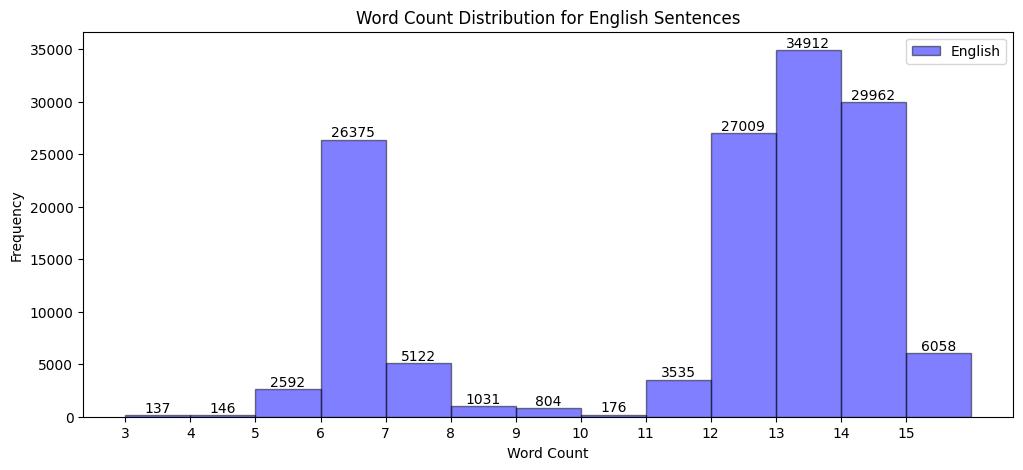

In [ ]:
unique_word_counts = sorted(df['ENG Length'].unique())
extended_bins = unique_word_counts + [unique_word_counts[-1] + 1]

plt.figure(figsize=(12, 5))
counts, bins, bars = plt.hist(df['ENG Length'], bins=extended_bins, alpha=0.5, label='English', color='blue', edgecolor='black')

for count, x in zip(counts, bins[:-1]):
    plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.xticks(unique_word_counts)
plt.title('Word Count Distribution for English Sentences')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**The histogram displays the word count distribution for English sentences, with the majority of sentences having 13 or 14 words. The peak frequencies occur at 13 (34,912 occurrences) and 14 words (29,962 occurrences), suggesting that most of the sentences in the data are of mid-length. Shorter sentences (3–7 words) and longer ones (15+ words) are less common.**

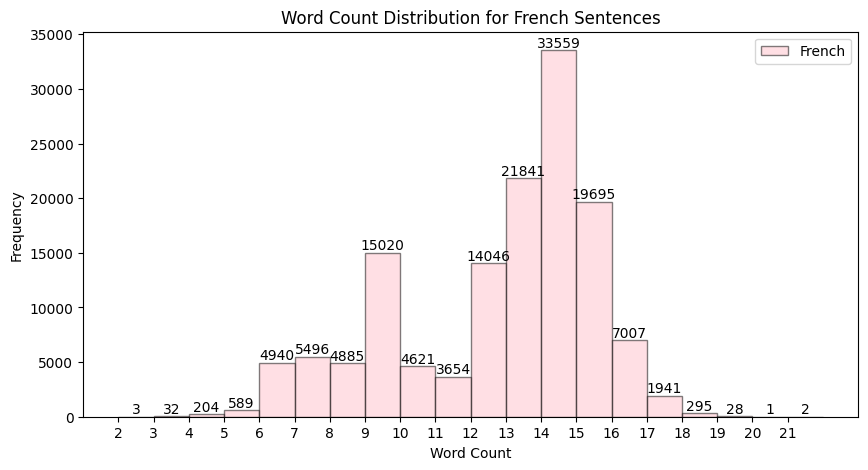

In [ ]:
unique_word_counts = sorted(df['FR Length'].unique())
extended_bins = unique_word_counts + [unique_word_counts[-1] + 1]

plt.figure(figsize=(10, 5))
counts, bins, bars = plt.hist(df['FR Length'], bins=extended_bins, alpha=0.5, label='French', color='pink', edgecolor='black')

for count, x in zip(counts, bins[:-1]):
    plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)

plt.xticks(unique_word_counts)

plt.title('Word Count Distribution for French Sentences')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**The histogram for French sentences shows that the most frequent word count is 14 words (33,559 occurrences), followed by 13 words (21,841 occurrences). Similar to the English distribution, mid-length sentences (13–15 words) dominate the dataset, while very short (2–5 words) or very long sentences (18+ words) are rare.**

In [ ]:
max_english_length = df['ENG Length'].max()
max_french_length = df['FR Length'].max()

print(f"The maximum length of an English sentence is: {max_english_length}")
print(f"The maximum length of a French sentence is: {max_french_length}")

The maximum length of an English sentence is: 15
The maximum length of a French sentence is: 21


**The maximum sentence lengths indicate that the longest English sentence has 15 words, while the longest French sentence has 21 words**.

**This information is going to be useful later when preparing the data for model training, especially for padding.**

In [ ]:
nltk.download('punkt_tab')

df['English_Tokens'] = df['English'].apply(word_tokenize)
df['French_Tokens'] = df['French'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**We apply the function word_tokenize to both the English and French columns, creating new columns 'English_Tokens' and 'French_Tokens' that store the tokenized words (tokens) for each sentence. Tokenization is a crucial step for text processing, as it prepares the sentences for further analysis or model training.**

In [ ]:
unique_english_words = set(word for tokens in df['English_Tokens'] for word in tokens)
unique_french_words = set(word for tokens in df['French_Tokens'] for word in tokens)

print(f"Number of unique words in English: {len(unique_english_words)}")
print(f"Number of unique words in French: {len(unique_french_words)}")

Number of unique words in English: 199
Number of unique words in French: 345


**In the previous code cell, we are findind the number of unique words in both datasets, where English has 199 unique words and French has 345**

In [ ]:
#We have already defined these 2 variables
#max_engish_length
#max_french_length

english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(df['English_Tokens'])

french_tokenizer = Tokenizer()
french_tokenizer.fit_on_texts(df['French_Tokens'])

english_tokens = english_tokenizer.texts_to_sequences(df['English_Tokens'])
french_tokens = french_tokenizer.texts_to_sequences(df['French_Tokens'])

english_padded = pad_sequences(english_tokens, maxlen=max_english_length, padding='post')
french_padded = pad_sequences(french_tokens, maxlen=max_french_length, padding='post')

**We create tokenizers for both English and French to convert words into integers, which the model can process.**

**We use the fit_on_texts method that builds a vocabulary from the tokenized sentences, assigning a unique integer to each word.**

**We also use the texts_to_sequences method to convert the sentences into sequences of integers based on the built vocabulary.**

**We ensure all sequences have the same length by padding them to the maximum sentence length (set to max_english_length and max_french_length), adding zeros at the end where necessary using the pad_sequences method.**

**These steps prepares the tokenized sentences for model training, ensuring consistency in input size.**

In [ ]:
def define_model(input_vocab, output_vocab, input_timesteps, output_timesteps):
    model = Sequential()
    model.add(Embedding(input_vocab, 256, mask_zero=True))
    model.add(LSTM(256))
    model.add(RepeatVector(output_timesteps))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(output_vocab, activation='softmax')))
    return model

**This function defines a sequence-to-sequence model for machine translation. It starts with an Embedding layer to represent words as dense vectors, followed by an LSTM layer to learn the sequence's context. The RepeatVector ensures the context is repeated for the output sequence length, and a second LSTM processes the output. The TimeDistributed layer applies a Dense layer with a softmax activation to generate the final word predictions for each time step. This model is designed to handle translation tasks, mapping input sequences to output sequences.**

In [ ]:
eng_vocab_size = len(english_tokenizer.word_index) + 1
fr_vocab_size = len(french_tokenizer.word_index) + 1

model = define_model(eng_vocab_size, fr_vocab_size, max_english_length, max_french_length)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(english_padded,
          french_padded,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.5775 - loss: 1.8456 - val_accuracy: 0.7983 - val_loss: 0.6770
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8332 - loss: 0.5590 - val_accuracy: 0.9153 - val_loss: 0.2939
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9294 - loss: 0.2462 - val_accuracy: 0.9481 - val_loss: 0.1773
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9550 - loss: 0.1516 - val_accuracy: 0.9569 - val_loss: 0.1405
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9659 - loss: 0.1106 - val_accuracy: 0.9686 - val_loss: 0.1044
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9717 - loss: 0.0919 - val_accuracy: 0.9744 - val_loss: 0.0847
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9779 - loss: 0.0721 - val_accuracy: 0.9733 - val_loss: 0.0881
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9815 -

**The model shows strong improvement over the 10 epochs:**

**Training accuracy increases consistently, starting at 57.75% in the first epoch and reaching 98.60% by the 10th epoch.**

**Training loss decreases from 1.8456 to 0.0453, indicating the model is learning effectively.**

**Validation accuracy also improves, rising from 79.83% in epoch 1 to 98.05% in epoch 10, showing that the model generalizes well to unseen data.**

**Validation loss decreases from 0.6770 to 0.0667, further supporting that the model is learning and not overfitting.**

**Overall, the model is converging well, with high accuracy on both the training and validation sets.**

In [ ]:
#This function translates an input English sentence into French by tokenizing, predicting the translation using the model,
#and converting the output tokens back into a French sentence.

def english_to_french(input_sentence, english_tokenizer, french_tokenizer, model, max_english_length, max_french_length):
    input_tokens = english_tokenizer.texts_to_sequences([input_sentence])
    input_padded = pad_sequences(input_tokens, maxlen=max_english_length, padding='post')

    predicted_output = model.predict(input_padded)

    output_sequence = np.argmax(predicted_output, axis=-1)
    output_sentence = []

    for token in output_sequence[0]:
        if token == 0:
            continue
        word = french_tokenizer.index_word.get(token, '')
        output_sentence.append(word)

    french_sentence = ' '.join(output_sentence)
    return french_sentence

In [ ]:
input = "she is driving the truck"

french_translation = english_to_french(input, english_tokenizer, french_tokenizer, model, max_english_length, max_french_length)
print(french_translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
elle conduit le nouveau camion


**The model translated the English sentence ("She is driving the truck") into French as ("Elle conduit le nouveau camion"), which means ("She is driving the new truck"). The translation is mostly correct, though it slightly altered "the truck" to "the new truck." This could be due to the model's training or vocabulary.**

#Lets Try to improve our model

In [ ]:
#The addition of the **Bidirectional LSTM** layer allows the model to learn from both past and future context in the input sequence,
#improving its ability to capture dependencies in translation tasks.

def define_model2(input_vocab, output_vocab, input_timesteps, output_timesteps):

    model = Sequential()
    model.add(Embedding(input_vocab, 256, mask_zero=True)) #Stays the same
    model.add(Bidirectional(LSTM(256)))
    model.add(RepeatVector(output_timesteps)) #Stays the same
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(output_vocab, activation='softmax')))

    return model

model2 = define_model2(eng_vocab_size, fr_vocab_size, max_english_length, max_french_length)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model2.fit(english_padded,
           french_padded,
           batch_size=64,
           epochs=10,
           validation_split=0.2)


Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.6533 - loss: 1.4647 - val_accuracy: 0.9075 - val_loss: 0.3097
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.9271 - loss: 0.2463 - val_accuracy: 0.9527 - val_loss: 0.1520
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9576 - loss: 0.1380 - val_accuracy: 0.9662 - val_loss: 0.1082
Epoch 4/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9710 - loss: 0.0920 - val_accuracy: 0.9668 - val_loss: 0.1085
Epoch 5/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9747 - loss: 0.0812 - val_accuracy: 0.9738 - val_loss: 0.0936
Epoch 6/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.9817 - loss: 0.0594 - val_accuracy: 0.9777 - val_loss: 0.0728
Epoch 7/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.9841 - loss: 0.0497 - val_accuracy: 0.9776 - val_loss: 0.0746
Epoch 8/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9868 -

**The new model shows significant improvement in both training and validation performance:**

**Training accuracy starts at 65.33% in the first epoch and reaches 99.07% by the 10th epoch.**

**Training loss decreases from 1.4647 to 0.0298, indicating effective learning.**

**Validation accuracy increases from 90.75% in epoch 1 to 98.21% in epoch 10, demonstrating strong generalization.**

**Validation loss decreases from 0.3097 to 0.0627, further showing that the model is improving and not overfitting.**

**Overall, the Bidirectional LSTM has helped enhance the model's performance, as evidenced by faster convergence and higher accuracy.**

In [ ]:
def predict_translation(input_sentence, model, english_tokenizer, french_tokenizer, max_english_length, max_french_length):
    input_sequence = english_tokenizer.texts_to_sequences([input_sentence])

    input_padded = pad_sequences(input_sequence, maxlen=max_english_length, padding='post')

    predicted_sequence = model.predict(input_padded)

    predicted_words = []
    for i in range(predicted_sequence.shape[1]):
        predicted_word_index = np.argmax(predicted_sequence[0, i, :])
        if predicted_word_index != 0:
            predicted_word = french_tokenizer.index_word.get(predicted_word_index)
            predicted_words.append(predicted_word)

    predicted_sentence = ' '.join(predicted_words)

    return predicted_sentence

In [ ]:
input = "i am going to paris"

predicted_french_sentence = predict_translation(input, model2, english_tokenizer, french_tokenizer, max_english_length, max_french_length)

print(predicted_french_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
vais je à paris


**The model translated the English sentence ("I am going to Paris") into French as ("Vais-je à Paris"), which means ("Am I going to Paris"). The model generated a slightly different meaning by interpreting the sentence as a question, which could be due to the way it was trained or the phrasing it encountered in the dataset.**

#Conclusion

**The model performed well, achieving high accuracy on both training and validation data, with improvements in both loss and accuracy throughout the epochs. However, the model's translation of certain sentences, such as "I am going to Paris," reflected slight inconsistencies, demonstrating room for improvement in capturing more nuanced translations.**

**Ways to Improve the Model:**

1-**A simple adjustment is to increase the number of LSTM units from 256 to 512, allowing the model more capacity to capture complex patterns. Similarly, increasing the embedding dimension from 256 to 512 enables the model to represent words more richly, improving its understanding of word relationships and enhancing performance.**

2-**Hyperparameter Tuning like optimizing the learning rate, batch size, and model dimensions through hyperparameter tuning can help tailor the architecture to the data, leading to better results.**

3-**Using pre-trained embeddings like GloVe provides the model with rich semantic representations from large corpora, boosting its ability to understand word relationships and enhancing overall performance.**

4-**Adding more LSTM layers can help the model capture more complex patterns, though this increases the computational cost and needs careful consideration to balance performance and efficiency.**